## heat map

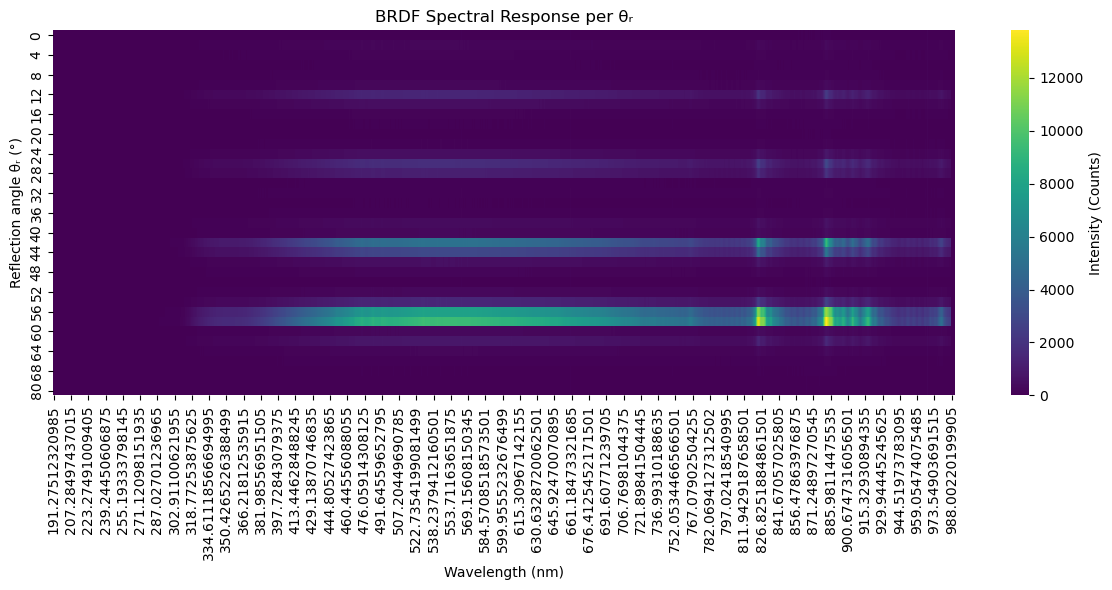

In [6]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- Set folder path for one module ---
module_folder = 'Module1_20250506_144218'  # Change if needed
full_path = os.path.join(os.getcwd(), module_folder)

# --- Pattern to extract angles from filename ---
pattern = r"ti_(\d+)_pi_(\d+)_tr_(\d+)_pr_(\d+)_int_\d+_ref_\d+\.csv"

# --- Store all spectra ---
spectra_data = []

for fname in os.listdir(full_path):
    if fname.endswith('.csv') and re.match(pattern, fname):
        match = re.match(pattern, fname)
        theta_i = int(match.group(1))
        phi_i = int(match.group(2))
        theta_r = int(match.group(3))
        phi_r = int(match.group(4))

        fpath = os.path.join(full_path, fname)
        df = pd.read_csv(fpath)

        # Clean header if needed
        if df.columns[0] != 'Wavelengths':
            df.columns = ['Wavelengths', 'Counts']

        df['theta_i'] = theta_i
        df['phi_i'] = phi_i
        df['theta_r'] = theta_r
        df['phi_r'] = phi_r

        spectra_data.append(df)

# --- Concatenate all into one dataframe ---
all_spectra = pd.concat(spectra_data, ignore_index=True)

# --- Pivot for heatmap: rows = theta_r, cols = wavelength ---
pivot_df = all_spectra.pivot_table(
    index='theta_r',
    columns='Wavelengths',
    values='Counts',
    aggfunc='mean'
)

# --- Sort theta_r for clarity ---
pivot_df = pivot_df.sort_index()

# --- Plot ---
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, cmap='viridis', cbar_kws={'label': 'Intensity (Counts)'})
plt.title('BRDF Spectral Response per θᵣ')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflection angle θᵣ (°)')
plt.tight_layout()
plt.show()

# Visualize reflectance vs. wavelength for fixed θᵢ and varying θᵣ
### For one module: how the reflectance spectrum changes for fixed incident angle as you vary the reflection direction

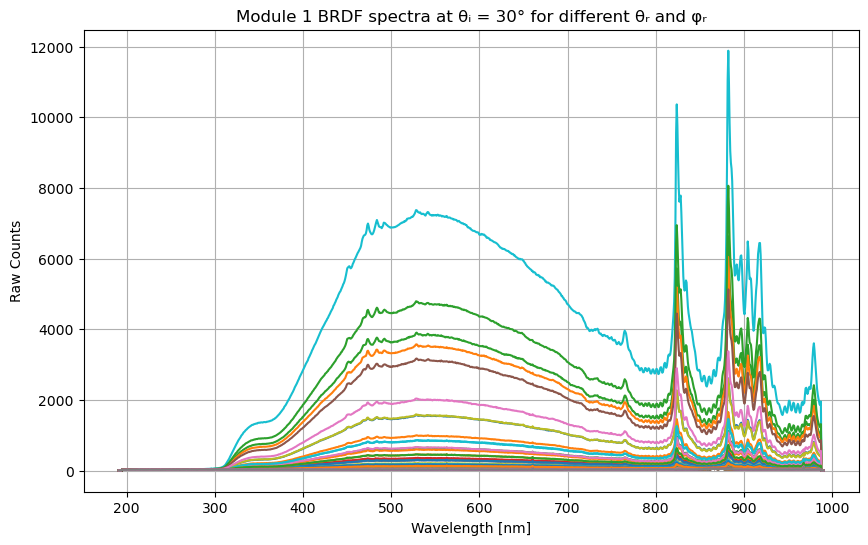

In [27]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# Folder where your CSVs are stored
folder = "Module1_20250506_144218"

# Regular expression to parse the filename
pattern = re.compile(r"ti_(\d+)_pi_(\d+)_tr_(\d+)_pr_(\d+)_int_\d+_ref_\d+\.csv")

# Choose the incident angle to analyze
target_theta_i = 30

data_by_theta_r = {}

for filename in os.listdir(folder):
    match = pattern.match(filename)
    if match:
        ti, pi, tr, pr = map(int, match.groups())
        if ti == target_theta_i:
            filepath = os.path.join(folder, filename)
            df = pd.read_csv(filepath, sep=',')  # Check delimiter if needed
            theta_r_label = f"tr={tr}, pr={pr}"
            data_by_theta_r[theta_r_label] = (df["Wavelengths"], df["Counts"])

# Plotting
plt.figure(figsize=(10, 6))
for label, (wavelengths, counts) in data_by_theta_r.items():
    plt.plot(wavelengths, counts, label=label)

plt.title(f"Module 1 BRDF spectra at θᵢ = {target_theta_i}° for different θᵣ and φᵣ")
plt.xlabel("Wavelength [nm]")
#plt.xlim(380,700) t
plt.ylabel("Raw Counts")
#plt.legend()
plt.grid(True)
#plt.tight_layout()
plt.show()

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

base_folder = "."  # Change this to the directory containing all 29 folders
pattern = re.compile(r"ti_(\d+)_pi_(\d+)_tr_(\d+)_pr_(\d+)_int_\d+_ref_\d+\.csv")

target_theta_i = 30
target_theta_r = 2

data_by_module = {}

for module_folder in os.listdir(base_folder):
    folder_path = os.path.join(base_folder, module_folder)
    if not os.path.isdir(folder_path):
        continue

    for filename in os.listdir(folder_path):
        match = pattern.match(filename)
        if match:
            ti, pi, tr, pr = map(int, match.groups())
            if ti == target_theta_i and tr == target_theta_r:
                filepath = os.path.join(folder_path, filename)
                df = pd.read_csv(filepath, sep=",")
                df.columns = df.columns.str.strip()
                label = module_folder
                data_by_module[label] = (df["Wavelengths"], df["Counts"])
                break  # Just one file per module (if there are multiple with same angle)

# Plotting
plt.figure(figsize=(10, 6))
for label, (wavelengths, counts) in data_by_module.items():
    plt.plot(wavelengths, counts, label=label)

plt.title(f"BRDF spectra at θᵢ = {target_theta_i}°, θᵣ = {target_theta_r}° for all modules")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Raw Counts")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

## Normalizing relative to module1 ref

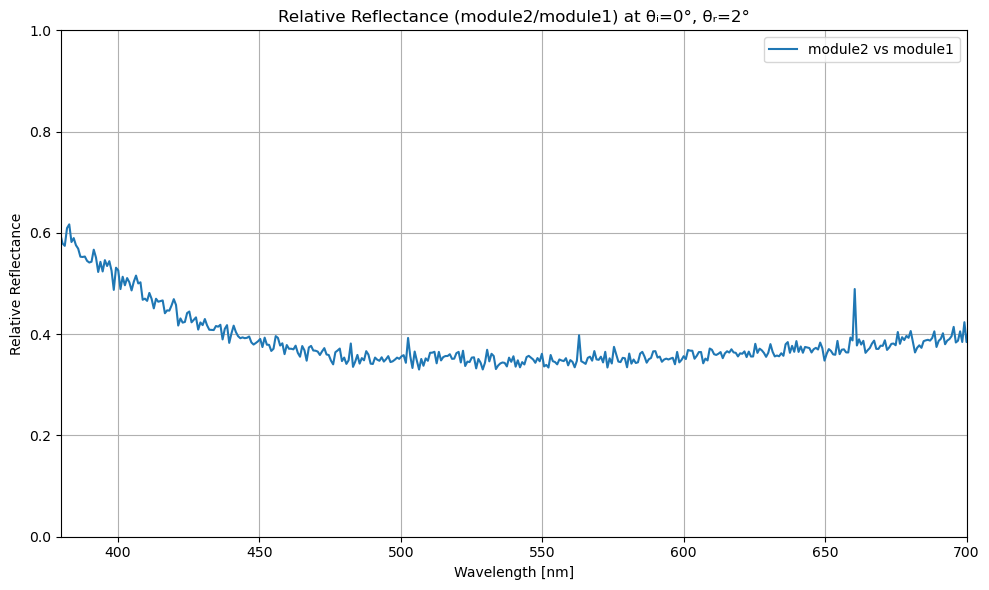

In [28]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

base_folder = "."
module_ref = "Module1_20250506_144218"
module_test = "Module2_20250507_101019"

# Choose the angle to compare
target_theta_i = 0
target_theta_r = 2

# File pattern to extract angles
pattern = re.compile(r"ti_(\d+)_pi_(\d+)_tr_(\d+)_pr_(\d+)_int_\d+_ref_\d+\.csv")

# Load reference (module1)
ref_file = None
for f in os.listdir(os.path.join(base_folder, module_ref)):
    m = pattern.match(f)
    if m:
        ti, pi, tr, pr = map(int, m.groups())
        if ti == target_theta_i and tr == target_theta_r:
            ref_file = os.path.join(base_folder, module_ref, f)
            break

available_angles_ref = []

for f in os.listdir(os.path.join(base_folder, module_ref)):
    m = pattern.match(f)
    if m:
        ti, pi, tr, pr = map(int, m.groups())
        available_angles_ref.append((ti, tr, pr))

#print("Available angle pairs in reference module:")
#for angle in sorted(available_angles_ref):
#    print(f"θᵢ={angle[0]}, θᵣ={angle[1]}")

if ref_file is None:
    raise FileNotFoundError("Reference file not found.")

df_ref = pd.read_csv(ref_file, sep=",")
df_ref.columns = df_ref.columns.str.strip()
wavelengths_ref = df_ref["Wavelengths"]
counts_ref = df_ref["Counts"]

# Load sample (module2)
test_file = None
for f in os.listdir(os.path.join(base_folder, module_test)):
    m = pattern.match(f)
    if m:
        ti, pi, tr, pr = map(int, m.groups())
        if ti == target_theta_i and tr == target_theta_r:
            test_file = os.path.join(base_folder, module_test, f)
            break

if test_file is None:
    raise FileNotFoundError("Test file for module2 not found.")

df_test = pd.read_csv(test_file, sep=",")
df_test.columns = df_test.columns.str.strip()

# Check wavelength match
if not df_test["Wavelengths"].equals(wavelengths_ref):
    raise ValueError("Wavelengths in module2 don't match module1.")

# Compute reflectance
reflectance = df_test["Counts"] / counts_ref

# Plot
plt.figure(figsize=(10, 6))
plt.plot(wavelengths_ref, reflectance, label="module2 vs module1")
plt.xlabel("Wavelength [nm]")
plt.xlim(380,700)
plt.ylim(0,1)
plt.ylabel("Relative Reflectance")
plt.title(f"Relative Reflectance (module2/module1) at θᵢ={target_theta_i}°, θᵣ={target_theta_r}°")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

In [ ]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

base_folder = "."
reference_module = "Module1_20250506_144218"
pattern = re.compile(r"ti_(\d+)_pi_(\d+)_tr_(\d+)_pr_(\d+)_int_\d+_ref_\d+\.csv")

target_theta_i = 30
target_theta_r = 2

reference_counts = None
reference_wavelengths = None

# Load reference
for filename in os.listdir(os.path.join(base_folder, reference_module)):
    match = pattern.match(filename)
    if match:
        ti, pi, tr, pr = map(int, match.groups())
        if ti == target_theta_i and tr == target_theta_r:
            df = pd.read_csv(os.path.join(base_folder, reference_module, filename))
            df.columns = df.columns.str.strip()
            reference_wavelengths = df["Wavelengths"]
            reference_counts = df["Counts"]
            break

if reference_counts is None:
    raise ValueError("Reference measurement not found.")

# Load other modules
reflectance_by_module = {}

for module_folder in os.listdir(base_folder):
    if module_folder == reference_module or not os.path.isdir(os.path.join(base_folder, module_folder)):
        continue

    for filename in os.listdir(os.path.join(base_folder, module_folder)):
        match = pattern.match(filename)
        if match:
            ti, pi, tr, pr = map(int, match.groups())
            if ti == target_theta_i and tr == target_theta_r:
                filepath = os.path.join(base_folder, module_folder, filename)
                df = pd.read_csv(filepath)
                df.columns = df.columns.str.strip()
                if not df["Wavelengths"].equals(reference_wavelengths):
                    raise ValueError(f"Wavelength mismatch in {module_folder}")
                reflectance = df["Counts"] / reference_counts
                reflectance_by_module[module_folder] = (df["Wavelengths"], reflectance)
                break

# Plotting
plt.figure(figsize=(10, 6))
for label, (wavelengths, refl) in reflectance_by_module.items():
    plt.plot(wavelengths, refl, label=label)

plt.title(f"Relative Reflectance (vs. {reference_module}) at θᵢ={target_theta_i}°, θᵣ={target_theta_r}°")
plt.xlabel("Wavelength [nm]")
plt.ylabel("Relative Reflectance")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()